# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [8]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

from collections import namedtuple
from collections import deque
import random

The QNetwork class below is used to create the deep learning architecture that is used to approximate Q* for the reinforcement learning problem. In this implementation, I am using 4 linear layers with relu activation after each one but the last linear layer. I could have used three layers like the previous assignment, but decided to instead try four layers to see how it would perform. Typically, deeper models with higher dimensions have a greater capacity to learn. 

In [10]:
class QNetwork(nn.Module): 
    
    def __init__(self, state_size, action_size,seed): 
        super(QNetwork,self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.state_size = state_size
        self.action_size = action_size
        
        ##Model Architecture 
        
        self.fc_layer1 = nn.Linear(self.state_size, self.state_size*4 )
        self.fc_layer2 = nn.Linear(self.state_size*4, self.state_size*8)
        self.fc_layer3 = nn.Linear(self.state_size*8, self.state_size*2)
        self.fc_layer4 = nn.Linear(self.state_size*2, self.action_size)
        
        self.relu = nn.ReLU()
        
    def forward(self,state): 
        
        x = self.fc_layer1(state)
        x = self.relu(x)
        
        x = self.fc_layer2(x)
        x = self.relu(x)
        
        x = self.fc_layer3(x)
        x = self.relu(x)
        
        x = self.fc_layer4(x)
        
        return x 
    

Below I am using the standard hyperparameters that we have previously used in our previous DQN exercises. Buffer size is the size of memory. Gamma is used to determine how important future rewards are versus immediate rewards. TAU is used in the soft update when copying over some fraction of the local q model weights to the target q model weights. LR is the learning rate used to determine how big of a step we take in the gradient direction when improving the model.

In [11]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64 
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Below I am creating an agent class which contains the blueprint for all the properties and methods needed for it to solve the bananna navigation problem. The code was adapted from our previous DQN exercise to work with the Unity Environment. While learning, the agent uses the gradient of the MSE loss between the TD target and current value for the local q table. 

In [12]:
class Agent():
        def __init__(self,state_size, action_size ,seed): 
            
            self.state_size = state_size 
            self.action_size = action_size  

            self.seed = random.seed(seed)
            
            #DQN-Network 
            self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
            
            #Replay Memory
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed) 
            self.t_step = 0
            
        def step(self, state, action, reward, next_state,done):
            
            #save experience in replay memory 
            self.memory.add(state, action, reward, next_state, done)
            
            self.t_step = (self.t_step + 1) % UPDATE_EVERY
            if self.t_step == 0: 
                
                if len(self.memory) > BATCH_SIZE:
                    experiences = self.memory.sample()
                    
                    self.learn(experiences, GAMMA)
                    
        def act(self, state, eps = 0):
            
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            
            self.qnetwork_local.eval()
            action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            
            if random.random() > eps: 
                return np.argmax(action_values.cpu().data.numpy())
            
            else: 
                return random.choice(np.arange(self.action_size))
            
        
        def learn(self,experiences, gamma): 
            
            states, actions, rewards, next_states , dones = experiences
            
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
            Q_expected = self.qnetwork_local(states).gather(1, actions)
            
            loss = F.mse_loss(Q_expected, Q_targets)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
            
            
        def soft_update(self,local_model,target_model, tau):
            """update formula θ_target = τ*θ_local + (1 - τ)*θ_target"""
            
            for target_param, local_param in zip(target_model.parameters(),local_model.parameters()): 
                target_param.data.copy_(tau*local_param.data +(1.0-tau)*target_param.data)
            

The replay buffer object is used to collect and sample experiences the agent has interacting with the environment. 

In [13]:
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size 
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size 
        self.experience = namedtuple("Experience",field_names=["state","action","reward","next_state","done"])
        self.seed = random.seed(seed)
        
        
    def add(self, state, action,reward, next_state, done): 
        e = self.experience(state, action,reward, next_state, done)
        self.memory.append(e)
        
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([int(e.done) for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

Below the environment is simulated where the agent learns while interacting with it. 

In [14]:
def dqn(env, n_episodes = 2000, max_t =1000, eps_start = 1.0 , eps_end=0.01, eps_decay=0.995):
    """
    max_t : max number of timesteps per episode
    eps_start : starting value of epsilon
    eps_end: min value of epsilon 
    eps_decay: multiplicative factor )(per episode) for decreasing epsilon 
    
    """
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start 
    agent = Agent(state_size = 37,action_size = 4, seed = 0)   
    
    for i_episode in range(1, n_episodes+1): 
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]     
        score = 0 
        
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]  
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            
            state = next_state 
            
            score += reward
        
            if done: 
                break
            
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


In [15]:
scores = dqn(env)

Episode 100	Average Score: 1.15
Episode 200	Average Score: 3.76
Episode 300	Average Score: 6.08
Episode 400	Average Score: 9.30
Episode 500	Average Score: 12.17
Episode 547	Average Score: 13.00
Environment solved in 447 episodes!	Average Score: 13.00


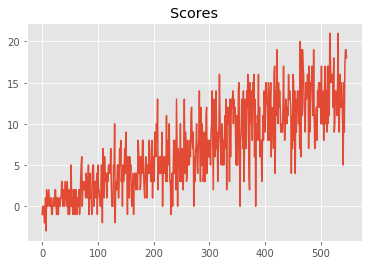

In [16]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

#### Future Work 

The agent uses standard experienced replay and fixed q-targets while learning. If the agent had been unable to solve the banana navigation problem in a reasonable amount of time, I would have explored using prioritized replay and double dqn to see how much performance would improve. These 2 improvements could be potential future work for this project. 